In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

In [62]:
home_path = '../dataset'
# img_size = 544
img_w, img_h = 1360, 800

In [63]:
files_list = os.listdir(home_path)
files_list.sort()
print(f'Total Image Files: {int(len(files_list) / 2)}')

Total Image Files: 741


In [64]:
def cal_mode(X):
    X = X.flatten()
    idx, cnts = np.unique(X, return_counts=True)
    nid = np.argmax(cnts)
    return idx[nid]

def get_img_path(f_name):
    fn_list = f_name.split('.')
    img_name, ext = '.'.join(fn_list[:-1]), fn_list[-1]
    for extension in ['.jpg', '.png']:
        img_path = os.path.join(home_path, img_name+extension)
        if os.path.isfile(img_path):
            return img_path
        
        
def get_img_vals(pil_img=None):
    np_img = np.asarray(pil_img)
    
    raf = np_img[..., 0]
    gaf = np_img[..., 1]
    baf = np_img[..., 2]
    
    r_mode = cal_mode(raf)
    g_mode = cal_mode(gaf)
    b_mode = cal_mode(baf)
    
    #print(r_mode, g_mode, b_mode)
    return (r_mode, g_mode, b_mode)
    
    # plt.imshow(pil_img)
    # plt.show()

In [65]:
def get_current_image(img_path):
    pil_img = Image.open(img_path)
    return pil_img
    
def get_obj_coordinates(curr_image, obj_data):
    c_img_w = curr_image.size[0]
    c_img_h = curr_image.size[1]
    
    cx = (float(data_item[1]) * c_img_w)
    cy = (float(data_item[2]) * c_img_h)
    bw = (float(data_item[3]) * c_img_w)
    bh = (float(data_item[4]) * c_img_h)
    # print(obj_data)
    
    left = int(cx - (bw / 2))
    top = int(cy - (bh / 2))
    right = int(cx + (bw / 2))
    bottom = int(cy + (bh / 2))
    
    cropped_img = curr_image.crop((left, top, right, bottom))
    return get_img_vals(cropped_img)

In [66]:
total_list = []

class_file = os.path.join(home_path, 'classes.txt')
with open(class_file) as fc:
    class_list = fc.readlines()

for file_name in tqdm(files_list):
    if file_name.endswith('.txt') and not file_name.startswith('class'):
        file_path = os.path.join(home_path, file_name)
        
        current_image = get_current_image(get_img_path(file_name))
        im_r_mode, im_g_mode, im_b_mode = get_img_vals(current_image)
        # print(im_r_mode, im_g_mode, im_b_mode)
        
        with open(file_path) as fp:
            # print(file_name)
            file_data = fp.readlines()
            for data_list in file_data:
                data_item = data_list.split(' ')
                obj_r_mode, obj_g_mode, obj_b_mode = get_obj_coordinates(curr_image=current_image,
                                   obj_data=data_item)
                try:
                    total_list.append([
                        file_path,
                        
                        #img_size * img_size,
                        #img_size,
                        #img_size,
                        img_w * img_h,
                        img_w,
                        img_h,
                        
                        class_list[int(data_item[0])].replace('\n', ''),
                        int(data_item[0]),
                        
                        int(im_r_mode),
                        int(im_g_mode),
                        int(im_b_mode),
                        
                        int(obj_r_mode),
                        int(obj_g_mode),
                        int(obj_b_mode),
                        
                        float(data_item[1]),
                        float(data_item[2]),
                        float(data_item[3]),
                        float(data_item[4])
                    ])
                except IndexError:
                    print('\nClass names must match with # of objects')
                    print('Please check your object labels or total of class names.\n')
                    exit(0)

df = pd.DataFrame(data=total_list,
                  columns=['img_path',
                           
                           'img_size',
                           'img_width',
                           'img_height',
                           
                           'class_name',
                           'class_idx',
                           
                           'im_r_mode',
                           'im_g_mode',
                           'im_b_mode',
                           
                           'obj_r_mode',
                           'obj_g_mode',
                           'obj_b_mode',
                           
                           'ncx',
                           'ncy',
                           'nbw',
                           'nbh'
                          ])


#df['cx'], df['cy'], df['bw'], df['bh'] = df.ncx * img_size, df.ncy * img_size, df.nbw * img_size, df.nbh * img_size
df['cx'], df['cy'], df['bw'], df['bh'] = df.ncx * img_w, df.ncy * img_h, df.nbw * img_w, df.nbh * img_h

df['obj_px'] = df['bw'] * df['bh']
df['obj_img_ratio'] = df['obj_px'] / df['img_size']

100%|███████████████████████████████████████| 1483/1483 [01:18<00:00, 18.94it/s]


In [67]:
df.head()

,img_path,img_size,img_width,img_height,class_name,class_idx,im_r_mode,im_g_mode,im_b_mode,obj_r_mode,...,ncx,ncy,nbw,nbh,cx,cy,bw,bh,obj_px,obj_img_ratio
0,../dataset/00000.txt,1088000,1360,800,danger,1,255,255,255,255,...,0.584191,0.535625,0.030147,0.04375,794.5,428.5,41.0,35.0,1435.0,0.001319
1,../dataset/00001.txt,1088000,1360,800,mandatory,2,255,255,255,255,...,0.737868,0.512500,0.030147,0.05500,1003.5,410.0,41.0,44.0,1804.0,0.001658
2,../dataset/00001.txt,1088000,1360,800,mandatory,2,255,255,255,255,...,0.304412,0.653750,0.041176,0.07250,414.0,523.0,56.0,58.0,3248.0,0.002985
3,../dataset/00001.txt,1088000,1360,800,other,3,255,255,255,255,...,0.736765,0.453125,0.042647,0.06875,1002.0,362.5,58.0,55.0,3190.0,0.002932
4,../dataset/00002.txt,1088000,1360,800,mandatory,2,255,255,255,28,...,0.697794,0.667500,0.083824,0.14500,949.0,534.0,114.0,116.0,13224.0,0.012154


In [68]:
class_grp = df.groupby(['class_name'])
class_grp.mean()

,img_size,img_width,img_height,class_idx,im_r_mode,im_g_mode,im_b_mode,obj_r_mode,obj_g_mode,obj_b_mode,ncx,ncy,nbw,nbh,cx,cy,bw,bh,obj_px,obj_img_ratio
class_name,,,,,,,,,,,,,,,,,,,,
danger,1088000.0,1360.0,800.0,1.0,237.219178,248.543379,252.744292,110.150685,93.214612,96.520548,0.590928,0.547220,0.038638,0.060171,803.662100,437.776256,52.547945,48.136986,3056.022831,0.002809
mandatory,1088000.0,1360.0,800.0,2.0,249.797546,255.000000,255.000000,83.865031,96.926380,148.331288,0.458282,0.606162,0.029267,0.051388,623.263804,484.929448,39.803681,41.110429,2069.803681,0.001902
other,1088000.0,1360.0,800.0,3.0,243.748175,255.000000,255.000000,132.941606,114.737226,119.083942,0.590621,0.529019,0.034865,0.058139,803.244526,423.215328,47.416058,46.510949,2785.153285,0.002560
prohibitory,1088000.0,1360.0,800.0,0.0,231.175943,247.041293,254.113106,102.001795,78.692998,88.269300,0.569465,0.575879,0.028907,0.049383,774.472172,460.702873,39.314183,39.506284,1879.357271,0.001727


In [74]:
df.iloc[1209]

img_path         ../dataset/00897.txt
img_size                      1088000
img_width                        1360
img_height                        800
class_name                      other
class_idx                           3
im_r_mode                         255
im_g_mode                         255
im_b_mode                         255
obj_r_mode                         26
obj_g_mode                         26
obj_b_mode                         31
ncx                               0.6
ncy                            0.6725
nbw                          0.017647
nbh                              0.03
cx                              816.0
cy                              538.0
bw                               24.0
bh                               24.0
obj_px                          576.0
obj_img_ratio                0.000529
Name: 1209, dtype: object

# TODO BLOCK

Object-Wise Pixel-Level Info (Modes)

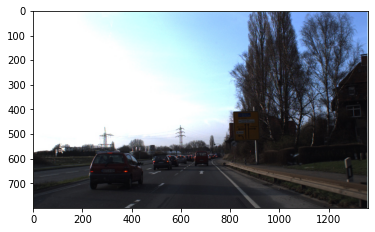

In [75]:
pil_img = Image.open('../dataset/00897.jpg')
plt.imshow(pil_img)

In [76]:
dfxi = df[df['img_path'] == '../dataset/00897.txt']
dfxi = dfxi[['cx', 'cy', 'bw', 'bh']].iloc[0]
dfxi

cx    816.0
cy    538.0
bw     24.0
bh     24.0
Name: 1209, dtype: float64

In [77]:
left = int(dfxi.cx - (dfxi.bw / 2))
top = int(dfxi.cy - (dfxi.bh / 2))
right = int(dfxi.cx + (dfxi.bw / 2))
bottom = int(dfxi.cy + (dfxi.bh / 2))
left, top

(804, 526)

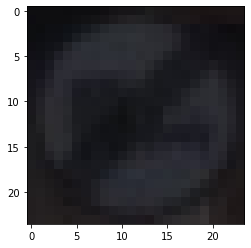

In [78]:
crop_img = pil_img.crop((left, top, right, bottom))
plt.imshow(crop_img)

In [79]:
cropped_np_img = np.asarray(crop_img)
cropped_np_img.shape

(24, 24, 3)

In [82]:
cal_mode(cropped_np_img[..., 0].flatten())

26

## Practice Block

In [ ]:
pil_img = Image.open('')
np_img = np.asarray(pil_img)
np_img.shape

In [ ]:
raf_img = np_img[..., 0]
gaf_img = np_img[..., 1]
baf_img = np_img[..., 2]

In [ ]:

idx, cnts

In [ ]:
np.argmax(cnts)

In [ ]:
idx[175]